In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

import scipy

from scipy.optimize import fsolve

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

import os
import sys

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools



# sns.set_style('dark')
# sns.set_style('ticks')
# plt.style.use('dark_background')

In [2]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)



In [3]:
### Now that we've drawn that line, let's purge the Li2019 mutants from the list


merged_fitness = merged_fitness[~merged_fitness['source_publication'].isin(['Li2019'])]

In [4]:
evo_cond_list = ['Evo1D','Evo2D','Evo3D']
anc_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

for anc in anc_list:
    for evo_cond in evo_cond_list:
        this_pairing = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['evolution_condition']==evo_cond)]
        
        print(anc,evo_cond,len(this_pairing))

WT Evo1D 0
WT Evo2D 506
WT Evo3D 0
CYR1 Evo1D 211
CYR1 Evo2D 535
CYR1 Evo3D 35
GPB2 Evo1D 169
GPB2 Evo2D 1219
GPB2 Evo3D 34
TOR1 Evo1D 203
TOR1 Evo2D 726
TOR1 Evo3D 2
IRA1_MIS Evo1D 191
IRA1_MIS Evo2D 143
IRA1_MIS Evo3D 32
IRA1_NON Evo1D 12
IRA1_NON Evo2D 95
IRA1_NON Evo3D 135


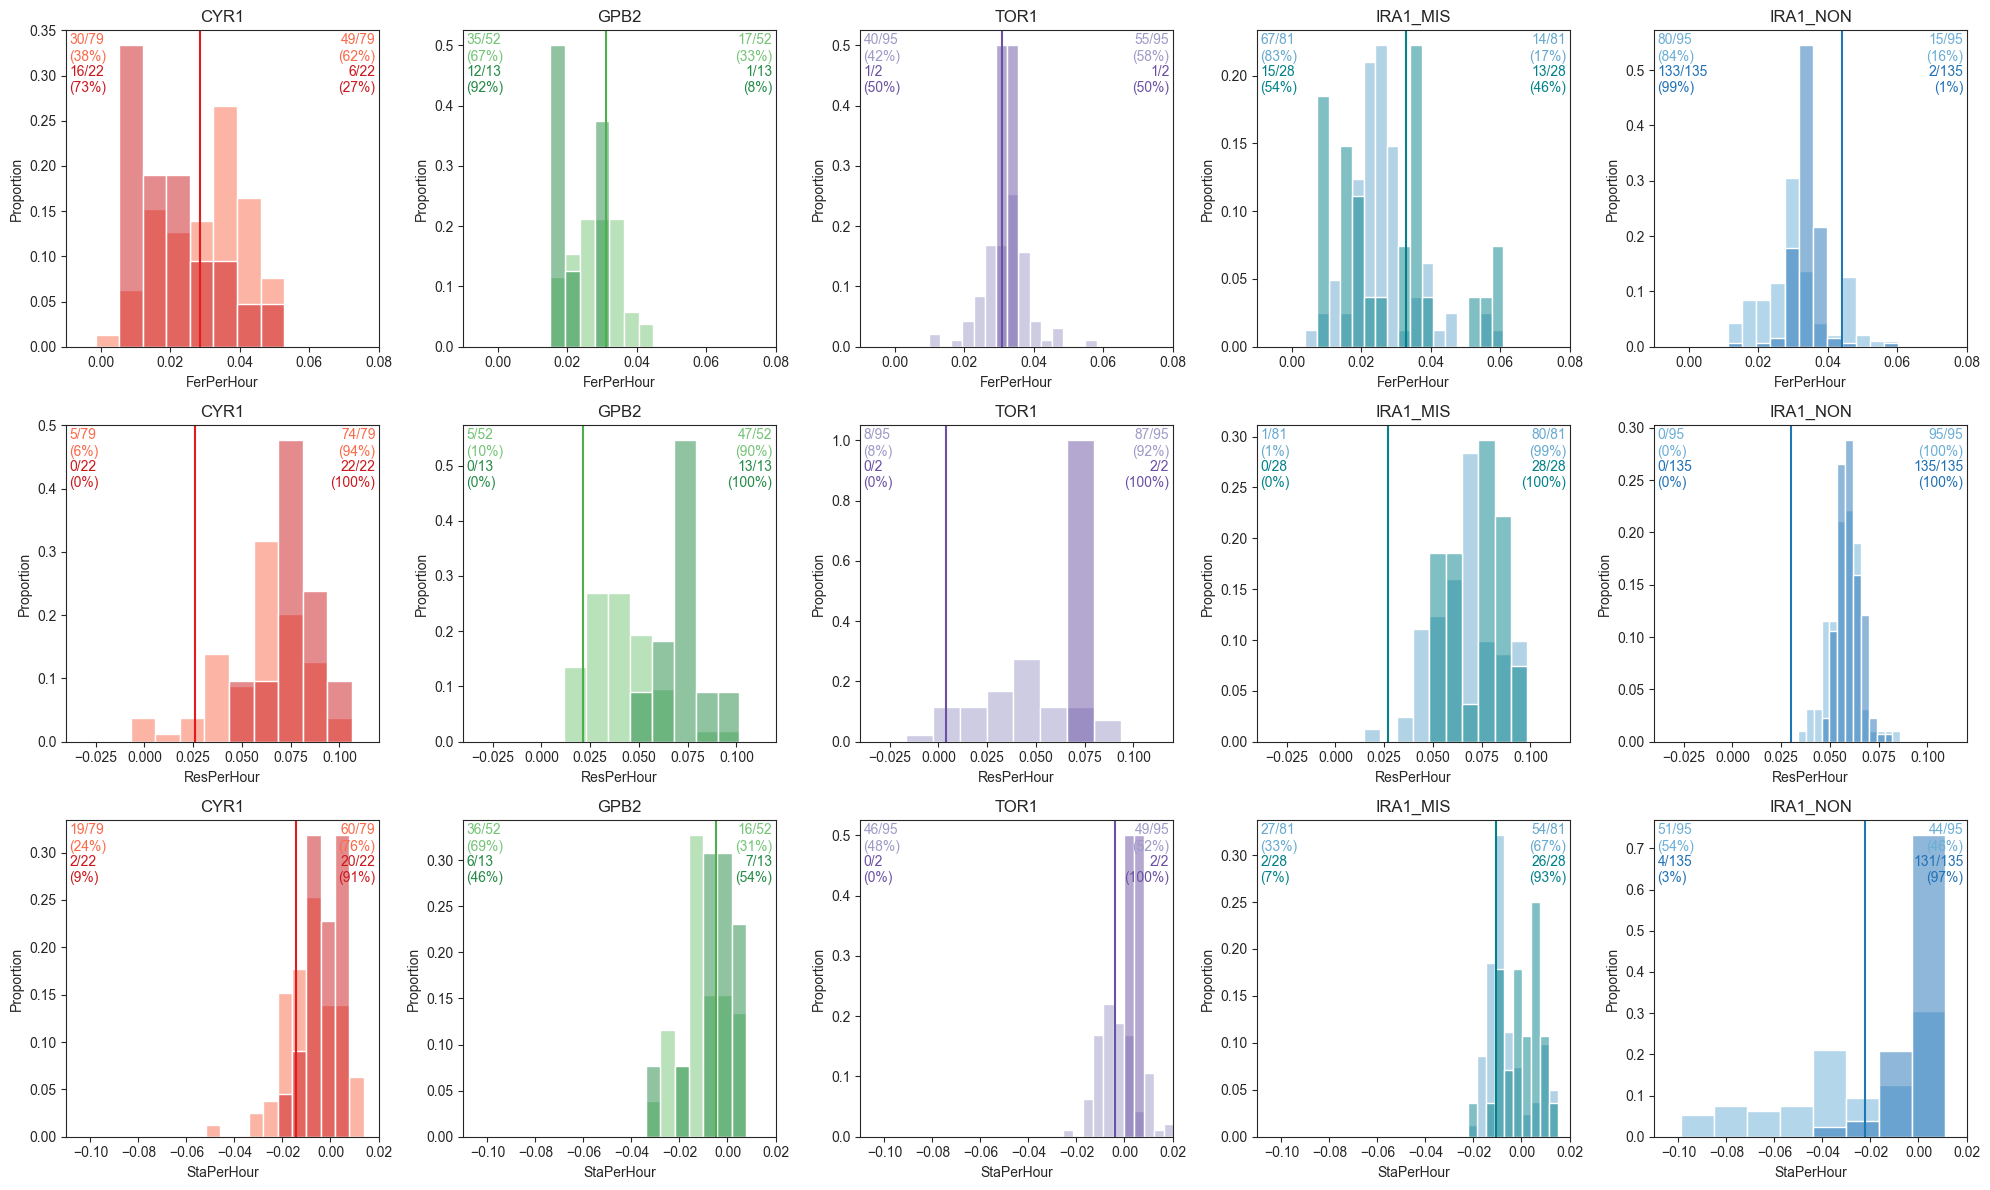

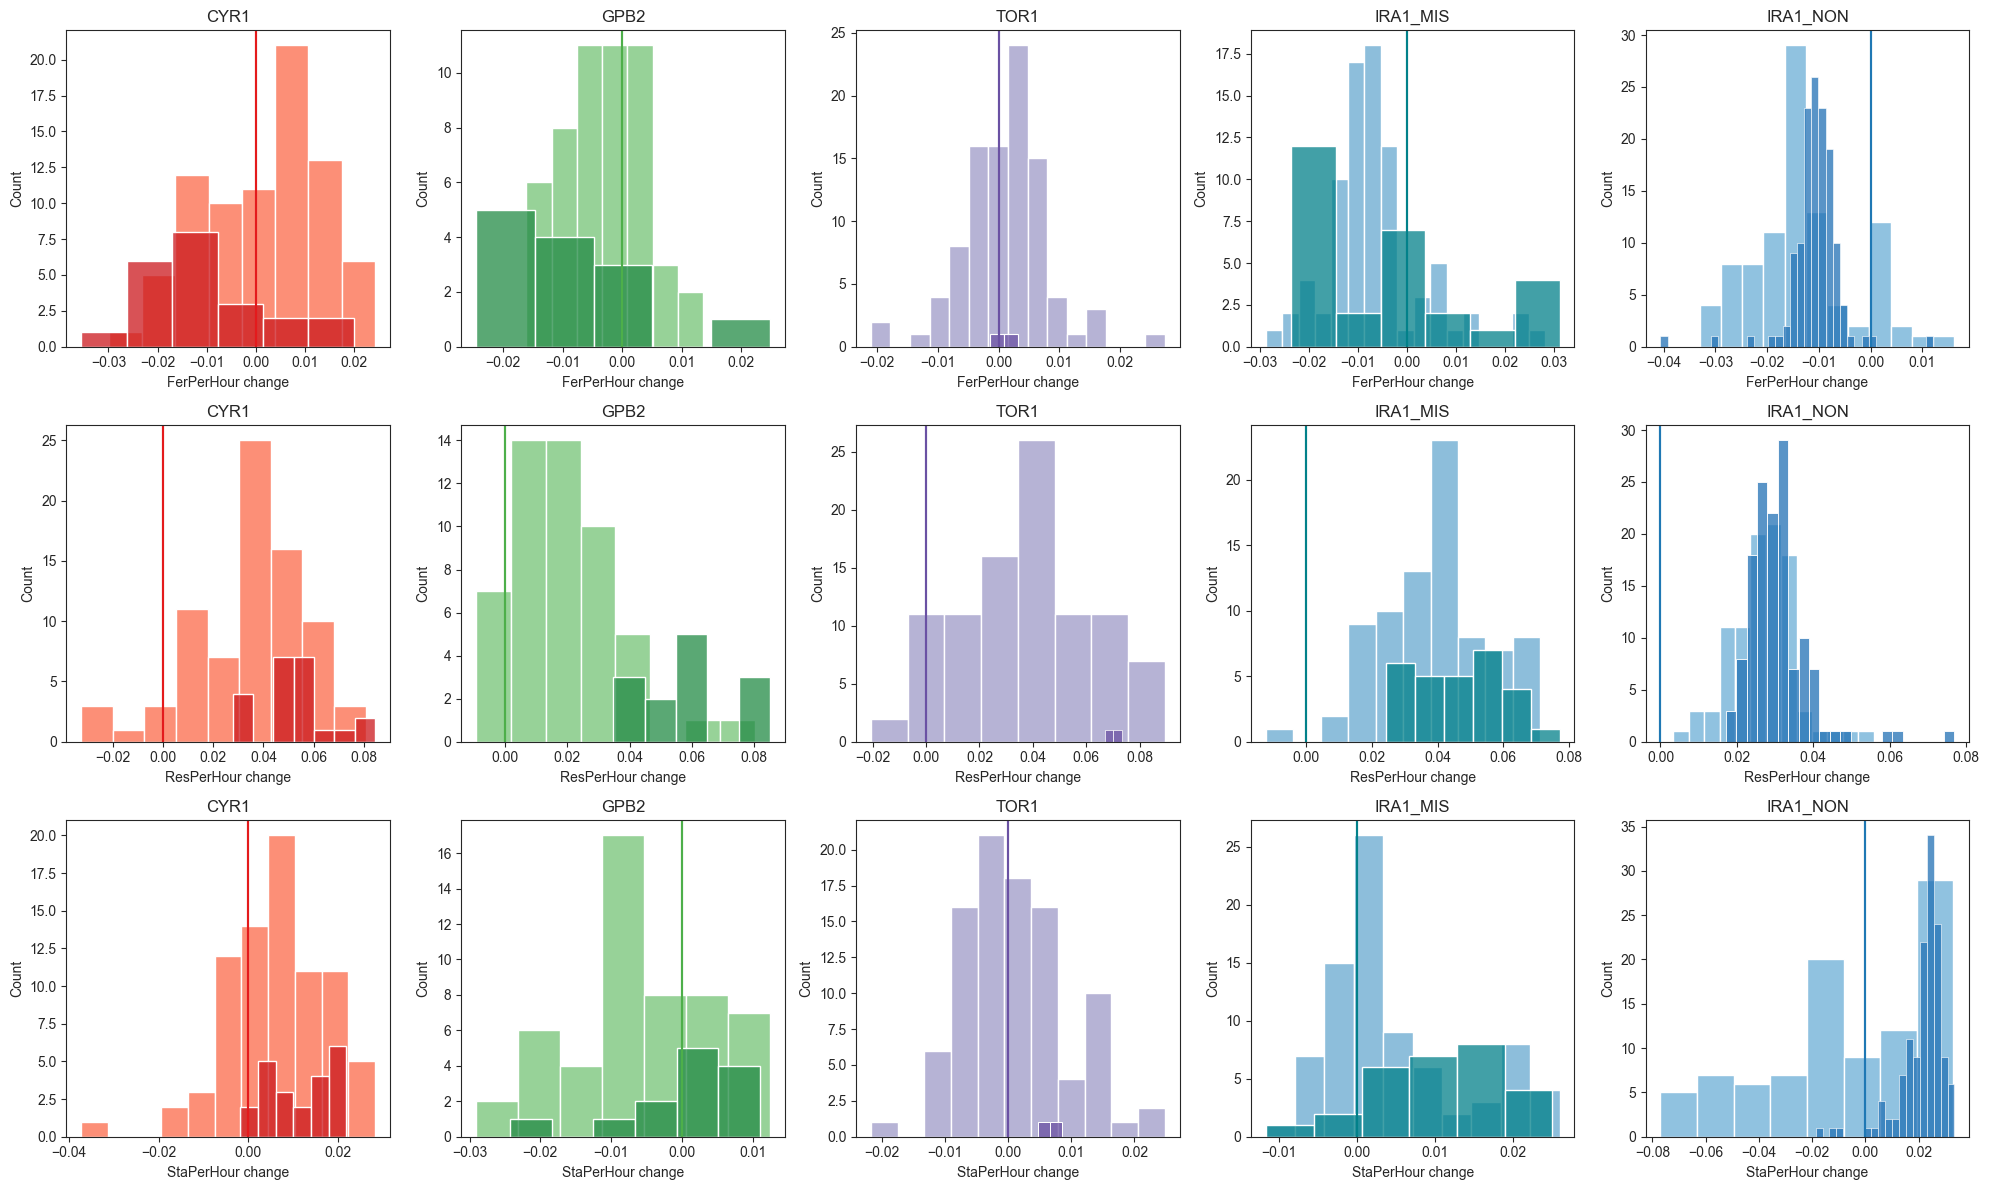

In [41]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
# evo_cond_list = ['Evo1D','Evo2D','Evo3D']
evo_cond_list = ['Evo2D','Evo3D']

performance_list = ['FerPerHour','ResPerHour','StaPerHour']

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True

ancestor_list = ['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']


# cutoff for standard deviation
multiplier = 1.0

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

counter = 1

plt.figure(figsize=(4*len(ancestor_list),4*len(performance_list)))
for performance in performance_list:
    for ancestor in ancestor_list:
        plt.subplot(len(performance_list),len(ancestor_list),counter)
        plt.title(f'{ancestor}')
        counter += 1
        this_anc = noLi2019[noLi2019['ancestor']==ancestor]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancestor]]

        
        for e,evo_cond in enumerate(evo_cond_list):
        
#             interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
    
            if e == 0:
                bins = np.histogram_bin_edges(this_data[performance].values, bins='auto')
        
            sns.histplot(this_data[performance].values,stat='proportion',bins=bins,
                         ax=plt.gca(),color=tools.anc_evo_cond_color_map[ancestor][evo_cond],label=evo_cond,alpha=0.5)
            
            above = np.sum(this_data[performance].values>background_mutant[performance].values[0])
            below = len(this_data[performance].values) - above
            
            plt.text(s=f'{above}/{above+below}\n({above/(above+below):.0%})',
                                     x=0.99,y=0.99-0.1*e,transform=plt.gca().transAxes,
                                     ha='right',va='top',color=tools.anc_evo_cond_color_map[ancestor][evo_cond])
            
            plt.text(s=f'{below}/{above+below}\n({below/(above+below):.0%})',
                                     x=0.01,y=0.99-0.1*e,transform=plt.gca().transAxes,
                                     ha='left',va='top',color=tools.anc_evo_cond_color_map[ancestor][evo_cond])
            
        plt.axvline(background_mutant[performance].values[0],color=tools.anc_color_map[ancestor])
#             plt.axvspan(background_mutant[performance].values[0]-background_mutant[performance+'_error'].values[0],
#                         background_mutant[performance].values[0]+background_mutant[performance+'_error'].values[0],
#                        )

        plt.xlabel(performance)
        plt.xlim(tools.lims[performance][0],tools.lims[performance][1])
#         plt.legend(loc=)
        

            
            
plt.tight_layout()
plt.savefig(f'{home_dir}/figures/analysis/performance_change/performance_change_comparison_dists.png',dpi=300)
            
counter = 1
            
plt.figure(figsize=(4*len(ancestor_list),4*len(performance_list)))
for performance in performance_list:
    for ancestor in ancestor_list:
        plt.subplot(len(performance_list),len(ancestor_list),counter)
        plt.title(f'{ancestor}')
        counter += 1
        this_anc = noLi2019[noLi2019['ancestor']==ancestor]

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
        
        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancestor]]

        
        for evo_cond in evo_cond_list:
        
#             interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
            sns.histplot(this_data[performance].values-background_mutant[performance].values[0],ax=plt.gca(),color=tools.anc_evo_cond_color_map[ancestor][evo_cond])
            
            plt.axvline(0,color=tools.anc_color_map[ancestor])
            
            plt.xlabel(f'{performance} change')
            
plt.tight_layout()
plt.savefig(f'{home_dir}/figures/analysis/performance_change/performance_change_comparison_dists_difference.png',dpi=300)


In [37]:
this_data[performance].values>background_mutant[performance].values[0]

array([ True,  True,  True, False,  True,  True, False,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
       False, False, False, False,  True, False, False,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True, False, False,  True, False,
       False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True, False,  True,  True])